In [1]:
from sklearn.datasets import fetch_openml

In [2]:
MNIST = fetch_openml("MNIST_784", version = 1)

In [3]:
MNIST.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, Y = MNIST['data'], MNIST['target']

In [7]:
X.shape

(70000, 784)

In [8]:
Y.shape

(70000,)

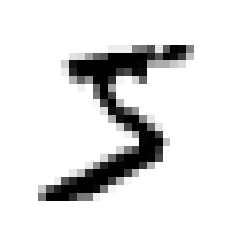

In [10]:
# Let's take a peak at one of the images
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis("off")
plt.show()

In [12]:
Y[0]

'5'

In [15]:
# Note that 5 is a string, most Ml algo doesn't deal with Strings, so let's cast it to int
import numpy as np
Y= Y.astype(np.uint8)

In [17]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [18]:
# Training Binary Classification: Let's make a binary classifier to predict whether a digit is 5 or not 5
y_train5 = (y_train == 5)
y_test5 = (y_test == 5)

In [20]:
# for this work, we can use SGD (Stochastic Gradient Descent Classifier) or SGDClassifier
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(random_state = 43)
SGD.fit(x_train, y_train5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=43, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
SGD.predict([some_digit])

array([ True])

our binary classifier is working fine.

In [31]:
# Measuring accuracy using cross validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(x_train, y_train5):
    clone_clf = clone(SGD)
    #print(train_index, test_index)
    x_train_fold = x_train[train_index]
    y_train_fold = y_train5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train5[test_index]
    
    clone_clf.fit(x_train_fold, y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred)) 

0.9629
0.96655
0.9638


In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(SGD, x_train, y_train5, cv = 3,scoring = "accuracy")

array([0.9629 , 0.96655, 0.9638 ])

In [33]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, x, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [34]:
never_5_classifier = Never5Classifier()


In [35]:
cross_val_score(never_5_classifier, x_train, y_train5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [36]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(SGD, x_train, y_train5, cv = 3)

In [37]:
y_train_pred

array([False, False, False, ...,  True, False, False])

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train5, y_train_pred)

array([[53756,   823],
       [ 1312,  4109]], dtype=int64)

In [42]:
y_train_perfect_prediction = y_train5
confusion_matrix(y_train5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precision = TP/(TP + FP)

TP is the number of true Positives, and FP is the number of false positives. A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct ( precision = 1/1 = 100% ). But this would not be very useful, since classifier would ignore all but one positive instance. So  precision is typically used along with another metric named recall, also called sensitivity or the true positive rate ( TPR): This is the ratio of positive instances that are correctly detected by the classifier. 

recall = TP/ (TP + FN)

FN is ofcourse False Negatives.


In [43]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train5, y_train_pred), recall_score(y_train5, y_train_pred))

0.8331305758313058 0.7579782327983767


In [44]:
from sklearn.metrics import f1_score
f1_score(y_train5, y_train_pred)

0.7937795807978364

In [45]:
y_score = SGD.decision_function([some_digit])
y_score

array([1633.17856965])

In [47]:
threshold = 0
scores = SGD.decision_function(x_train)

In [50]:
y_predict_2 = (scores >= threshold)

In [51]:
precision_score(y_train5, y_predict_2)

0.7648170417454045

In [52]:
recall_score(y_train5, y_predict_2)

0.8212506917542889

In [57]:
f1_score(y_train5, y_predict_2)

0.7920298879202988

In [53]:
threshold = 2000
y_predict_3 = (scores >= threshold)

In [54]:
precision_score(y_train5, y_predict_3)

0.9160537661678925

In [55]:
recall_score(y_train5, y_predict_3)

0.6662977310459325

In [56]:
f1_score(y_train5, y_predict_3)

0.7714651858180265

In [59]:
Y_scores_curve = cross_val_predict(SGD, x_train, y_train5, cv = 3, method = 'decision_function')

In [60]:
from sklearn.metrics import precision_recall_curve

In [62]:
precisions, recalls, thresholds = precision_recall_curve(y_train5, Y_scores_curve)

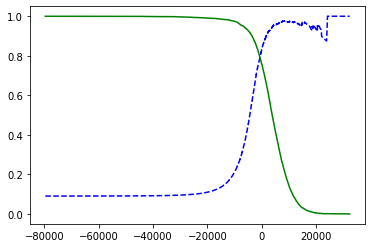

In [63]:
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], 'b--', label = "Precision")
    plt.plot(threshold, recall[:-1], "g-", label = "Recall")
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

